Perform the SA with the image of the audio file

Workflow to covert spectogram to images:
1. Load an audio file.

2. Compute its mel-spectrogram.

3. Convert the spectrogram to decibel scale for better visualization.

4. Normalize and scale it into an image-like format.

5. Save the spectrogram as a .jpg file.

In [ ]:
import numpy as np
import os
from skimage.io import imread
import librosa
import librosa.display
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import confusion_matrix, f1_score, precision_score, recall_score, accuracy_score
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import shutil
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader
from utils import *

In [2]:
def saveImg(f, fp):
    f = np.flip(f, axis=0)
    plt.figure()
    plt.axis('off')
    plt.imsave(fp, f, format='png')
    plt.clf()

def showImg(f):
    f = np.flip(f, axis=0)
    plt.figure()
    plt.axis('off')
    plt.clf()
    plt.imshow(f)

In [3]:
def from_audio_to_image(audio_path, save_dir):
    file_name = audio_path.split('/')[3].split('.')[0] + '.png'
    fname = os.path.join(save_dir, file_name)
    print(fname)

    # Check if the image already exists
    if os.path.exists(fname):
        print(f"File {fname} already exists. \tSkipping...")
        return

    f_dim = 128
    y, sr = librosa.load(audio_path, sr=None)
    M = librosa.feature.melspectrogram(y=y, sr=sr)
    f = librosa.amplitude_to_db(M, ref=np.max)
    img = np.zeros((f.shape[0], f_dim))
    xWidth = min(f.shape[1], f_dim)
    img[:, :xWidth] = f[:,:xWidth]
    print("saving image:\t", fname, "\n")
    saveImg(img, fname)

In [4]:
def from_audio_to_image_df(df, save_dir):
    # Convert the wav audio file into the mel spectrogram image
    for audio_path in df['audio_path']:
        from_audio_to_image(audio_path, save_dir)

In [ ]:
# val_dataset = pd.read_excel('../Dataset/val.xlsx')
# save_dir = "../Dataset/images/val"
# print("VALIDATION")
# from_audio_to_image_df(val_dataset, save_dir)
# # Amount of images in the save_dir folder
# print("\n-->DONE: ", len(os.listdir(save_dir)), " images")

# test_dataset = pd.read_excel('../Dataset/test.xlsx')
# save_dir = "../Dataset/images/test"
# print("TEST")
# from_audio_to_image_df(test_dataset, save_dir)
# # Amount of images in the save_dir folder
# print("\n-->DONE: ", len(os.listdir(save_dir)), " images")

# train_dataset = pd.read_excel('../Dataset/train_balanced.xlsx')
# save_dir = "../Dataset/images/train"
# print(len(train_dataset['audio_path'].unique()), " unique audio files in the dataset\n")
# print("TRAIN (balanced)")
# from_audio_to_image_df(train_dataset, save_dir)
# # Amount of images in the save_dir folder
# print("\n-->DONE: ", len(os.listdir(save_dir)), " images")

Prepare the image folders 

In [8]:
df_train = pd.read_excel('../Dataset/train_balanced.xlsx')
df_val = pd.read_excel('../Dataset/val.xlsx')
df_test = pd.read_excel('../Dataset/test.xlsx')

In [ ]:
def classes_img_subfolders(df, df_name):
    for _, row in df.iterrows():
        print(row['audio_path'], row['label'])
        if row['label'] == 2:
            destination_folder = f"../Dataset/images/{df_name}/positive"
        elif row['label'] == 1:
            destination_folder = f"../Dataset/images/{df_name}/neutral"
        elif row['label'] == 0:
            destination_folder = f"../Dataset/images/{df_name}/negative"

        audio_path = row['audio_path']
        image_path = audio_path.split('/')[3].split('.')[0] + '.png'
        source = f"../Dataset/images/{df_name}/{image_path}"
        dst = os.path.join(destination_folder, image_path)
        print("dest ", dst)
        print("source ", source)
        shutil.copy2(source, dst)
        print("\n-----------Done with ", df_name, "\n\n")

In [11]:
classes_img_subfolders(df_train, 'train')
classes_img_subfolders(df_val, 'val')
classes_img_subfolders(df_test, 'test')

../Dataset/all/1_3956.wav 2
dest  ../Dataset/images/train/positive\1_3956.png
source  ../Dataset/images/train/1_3956.png

-----------Done with  train 


../Dataset/all/1_4127.wav 2
dest  ../Dataset/images/train/positive\1_4127.png
source  ../Dataset/images/train/1_4127.png

-----------Done with  train 


../Dataset/all/1_1880.wav 2
dest  ../Dataset/images/train/positive\1_1880.png
source  ../Dataset/images/train/1_1880.png

-----------Done with  train 


../Dataset/all/2_550.wav 2
dest  ../Dataset/images/train/positive\2_550.png
source  ../Dataset/images/train/2_550.png

-----------Done with  train 


../Dataset/all/2_1700.wav 2
dest  ../Dataset/images/train/positive\2_1700.png
source  ../Dataset/images/train/2_1700.png

-----------Done with  train 


../Dataset/all/1_6609.wav 2
dest  ../Dataset/images/train/positive\1_6609.png
source  ../Dataset/images/train/1_6609.png

-----------Done with  train 


../Dataset/all/1_223.wav 2
dest  ../Dataset/images/train/positive\1_223.png
source  .

## Model

Parameters

In [ ]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
BATCH_SIZE = 16
EPOCHS = 10  
LEARNING_RATE = 1e-4
IMG_SIZE = 224 
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=LEARNING_RATE)

In [ ]:
train_dir = "../Dataset/images/train"
val_dir = "../Dataset/images/val"
test_dir = "../Dataset/images/test"

data_transforms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Standard ResNet normalization
])

Dataset and Dataloader

In [ ]:
train_dataset = datasets.ImageFolder(train_dir, transform=data_transforms)
val_dataset = datasets.ImageFolder(val_dir, transform=data_transforms)
test_dataset = datasets.ImageFolder(test_dir, transform=data_transforms)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

torch.Size([16, 3, 224, 224])


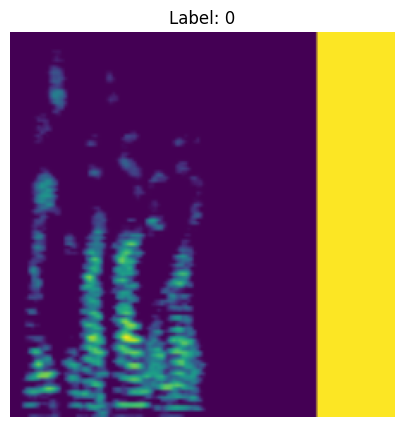

In [ ]:
dataiter = iter(train_loader)
images, labels = next(dataiter)
print(images.shape)  # Deve essere (batch_size, C, H, W)

# Decodifica l'immagine per la visualizzazione
def imshow(img):
    img = img.numpy().transpose((1, 2, 0))  # Da (C, H, W) a (H, W, C)
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    img = std * img + mean  # De-normalizzazione
    img = np.clip(img, 0, 1)  # Valori tra [0,1]
    plt.imshow(img)

# Scegli un indice a caso nel batch
idx = np.random.randint(len(images))

# Mostra l'immagine con la sua etichetta
plt.figure(figsize=(5,5))
imshow(images[idx])
plt.title(f"Label: {labels[idx].item()}")
plt.axis("off")
plt.show()

Load the model: **ResNet-50**

In [ ]:
model = models.resnet50(pretrained=True)
num_features = model.fc.in_features
model.fc = nn.Linear(num_features, 3)  
model = model.to(DEVICE)
torch.cuda.empty_cache()
torch.cuda.ipc_collect()
!nvidia-smi

c:\Users\alice\AppData\Local\pypoetry\Cache\virtualenvs\soundsentiment-HVhUS5V1-py3.12\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\alice\AppData\Local\pypoetry\Cache\virtualenvs\soundsentiment-HVhUS5V1-py3.12\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Sun Feb 16 17:03:43 2025       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 531.14                 Driver Version: 531.14       CUDA Version: 12.1     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                      TCC/WDDM | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf            Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce GTX 1650 w...  WDDM | 00000000:01:00.0 Off |                  N/A |
| N/A   58C    P0               12W /  N/A|    652MiB /  4096MiB |      6%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

Training

In [ ]:
patience = 3 
best_val_loss = np.inf
counter = 0  
train_losses_per_epoch = []
val_losses_per_epoch = []

fix_seed()
for epoch in range(EPOCHS):
    model.train()
    running_loss = 0.0
    all_preds = []
    all_labels = []

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        all_preds.extend(predicted.cpu().numpy()) 
        all_labels.extend(labels.cpu().numpy())  

    epoch_loss = running_loss / len(train_loader)
    train_losses_per_epoch.append(epoch_loss)
    train_f1 = f1_score(all_labels, all_preds, average="weighted")

    # ---------------------- Validation Phase ----------------------
    model.eval()
    val_running_loss = 0.0
    val_preds = []
    val_labels = []

    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_running_loss += loss.item()

            _, predicted = torch.max(outputs, 1)
            val_preds.extend(predicted.cpu().numpy())
            val_labels.extend(labels.cpu().numpy())

    val_loss = val_running_loss / len(val_loader)
    val_losses_per_epoch.append(val_loss)
    val_f1 = f1_score(val_labels, val_preds, average="weighted")

    print(f"Epoch {epoch+1}/{EPOCHS} - Train Loss: {epoch_loss:.4f} - Train F1: {train_f1:.4f} - Val Loss: {val_loss:.4f} - Val F1: {val_f1:.4f}")

    # ---------------------- Early Stopping ----------------------
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        counter = 0
        torch.save(model.state_dict(), "best_model.pth")
    else:
        counter += 1
        if counter >= patience:
            print("Early stopping triggered!")
            break

print("Train Losses per epoch:", train_losses_per_epoch)
print("Validation Losses per epoch:", val_losses_per_epoch)


Epoch 1/10 - Train Loss: 1.0246 - Train F1: 0.4760 - Val Loss: 1.1223 - Val F1: 0.4886
Epoch 2/10 - Train Loss: 0.6365 - Train F1: 0.7252 - Val Loss: 1.0593 - Val F1: 0.6186
Epoch 3/10 - Train Loss: 0.3093 - Train F1: 0.8793 - Val Loss: 0.9508 - Val F1: 0.7233
Epoch 4/10 - Train Loss: 0.1810 - Train F1: 0.9338 - Val Loss: 0.9011 - Val F1: 0.7576
Epoch 5/10 - Train Loss: 0.1240 - Train F1: 0.9568 - Val Loss: 1.0151 - Val F1: 0.7806
Epoch 6/10 - Train Loss: 0.0957 - Train F1: 0.9663 - Val Loss: 1.1292 - Val F1: 0.7528
Epoch 7/10 - Train Loss: 0.1001 - Train F1: 0.9650 - Val Loss: 1.2977 - Val F1: 0.7212
Early stopping triggered!
Train Losses per epoch: [1.024558496729307, 0.6365497238523795, 0.30932196815949775, 0.18102042485180694, 0.12402096552258195, 0.09573985064910066, 0.10013318306156045]
Validation Losses per epoch: [1.1223137918772272, 1.059339853799399, 0.9508211493422168, 0.9010894710434155, 1.0150620784488082, 1.1292335790332775, 1.297672526027675]


In [23]:
plot_epoch_losses(train_losses_per_epoch, val_losses_per_epoch)

Evaluation of the model in test set

In [ ]:
model.eval()
test_preds = []
test_labels = []
test_running_loss = 0.0
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        test_running_loss += loss.item()

        _, predicted = torch.max(outputs, 1)
        test_preds.extend(predicted.cpu().numpy())
        test_labels.extend(labels.cpu().numpy())

# Calcola metriche finali
test_loss = test_running_loss / len(test_loader)
test_f1 = f1_score(test_labels, test_preds, average="weighted")
test_precision = precision_score(test_labels, test_preds, average="weighted")
test_recall = recall_score(test_labels, test_preds, average="weighted")
test_accuracy = accuracy_score(test_labels, test_preds)

print(f"\nTest Results:")
print(f"Test Loss: {test_loss:.4f}")
print(f"Test F1-score: {test_f1:.4f}")
print(f"Test Precision: {test_precision:.4f}")
print(f"Test Recall: {test_recall:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")


Test Results:
Test Loss: 1.5613
Test F1-score: 0.6386
Test Precision: 0.7659
Test Recall: 0.5776
Test Accuracy: 0.5776


In [ ]:
plot_confusion_matrix(test_labels, test_preds, "Test")